## Neural Network Approach for Seasonal Items Forecasting of a Retail Store
## Vanilla Stacked LSTM, Bidirectional LSTM

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

/Users/yas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  app.launch_new_instance()


## Load Dataset

In [2]:
data= pd.read_excel('../data/MRP_data.xls')

## Edit columns names

In [3]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [4]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales by date

In [5]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [6]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [7]:
#furniture['sales']

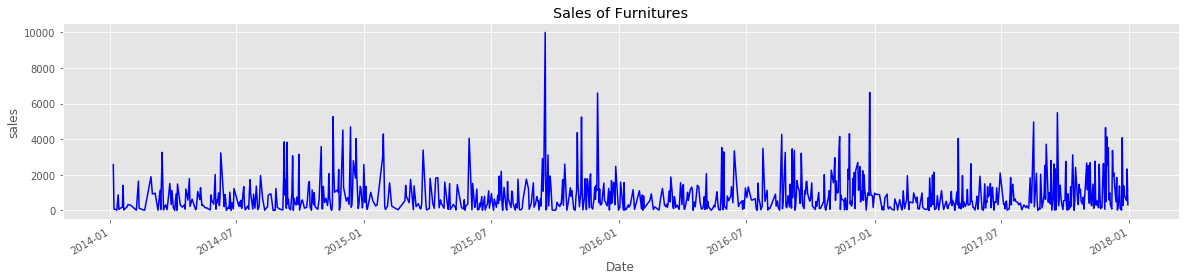

In [8]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furnitures")
plt.show()

In [9]:
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()
#df= avg_furniture_sales
#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

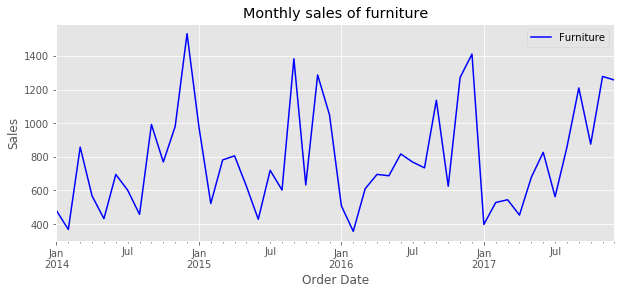

In [10]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

## Measure of prediction accuracy

In [11]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

## LSTM

In [12]:
train, test = np.array(df[:-12]), np.array(df[-12:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [13]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [14]:
n_input = 12
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

### Vanilla LSTM

In [15]:
######
#set the counter to repeat
n=3
store= np.zeros((12,n))
for i in range(n):
    model_vanilla = Sequential()
    model_vanilla.add(LSTM(50, activation='relu', input_shape=(12, 1)))
    #Add layer
    model_vanilla.add(Dense(100, activation='relu'))
    model_vanilla.add(Dense(100, activation='relu'))
    #Output
    model_vanilla.add(Dense(1))
    model_vanilla.compile(optimizer='adam', loss='mse')
    # 22
    model_vanilla.fit_generator(generator,epochs=200)
    
    pred_list = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list.append(model_vanilla.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[j]]],axis=1)

    df_predict_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store[:,i]=df_predict_vanilla['Prediction']
print(store)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 1/200
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
3/3 [==============================] - 2s 593ms/step - loss: 0.2399
Epoch 2/200
3/3 [==============================] - 0s 17ms/step - loss: 0.1964
Epoch 3/200
3/3 [==============================] - 0s 28ms/step - loss: 0.1640
Epoch 4/200
3/3 [==============================] - 0s 32ms/step - loss: 0.1310
Epoch 5/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0987
Epoch 6/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0787
Epoch 7/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0808
Epoch 8/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0807
Epoch 9/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0857
Epoch 10/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0839
Epoch 11/200
3/3 [===============

3/3 [==============================] - 0s 30ms/step - loss: 0.0071
Epoch 196/200
3/3 [==============================] - 0s 57ms/step - loss: 0.0078
Epoch 197/200
3/3 [==============================] - 0s 26ms/step - loss: 0.0073
Epoch 198/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0073
Epoch 199/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0067
Epoch 200/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0075
Epoch 1/200
3/3 [==============================] - 3s 843ms/step - loss: 0.2349
Epoch 2/200
3/3 [==============================] - 0s 33ms/step - loss: 0.1956
Epoch 3/200
3/3 [==============================] - 0s 37ms/step - loss: 0.1645
Epoch 4/200
3/3 [==============================] - 0s 31ms/step - loss: 0.1348
Epoch 5/200
3/3 [==============================] - 0s 34ms/step - loss: 0.1140
Epoch 6/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0917
Epoch 7/200
3/3 [==============================] - 0s

3/3 [==============================] - 0s 33ms/step - loss: 0.0156
Epoch 199/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0120
Epoch 200/200
3/3 [==============================] - 0s 88ms/step - loss: 0.0135
Epoch 1/200
3/3 [==============================] - 3s 1s/step - loss: 0.2665
Epoch 2/200
3/3 [==============================] - 0s 87ms/step - loss: 0.2163
Epoch 3/200
3/3 [==============================] - 0s 39ms/step - loss: 0.1881
Epoch 4/200
3/3 [==============================] - 0s 51ms/step - loss: 0.1586
Epoch 5/200
3/3 [==============================] - 0s 65ms/step - loss: 0.1286
Epoch 6/200
3/3 [==============================] - 0s 37ms/step - loss: 0.1053
Epoch 7/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0814
Epoch 8/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0734
Epoch 9/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0839
Epoch 10/200
3/3 [==============================] - 0s 38ms/st

In [16]:
final_vanilla= np.zeros((store.shape[0],1))

#final_vanilla= np.zeros((store.shape[0],1))
for i in range(store.shape[0]):
    
    final_vanilla[i]=np.mean(store[i,:])
final_vanilla=final_vanilla.reshape((12,))

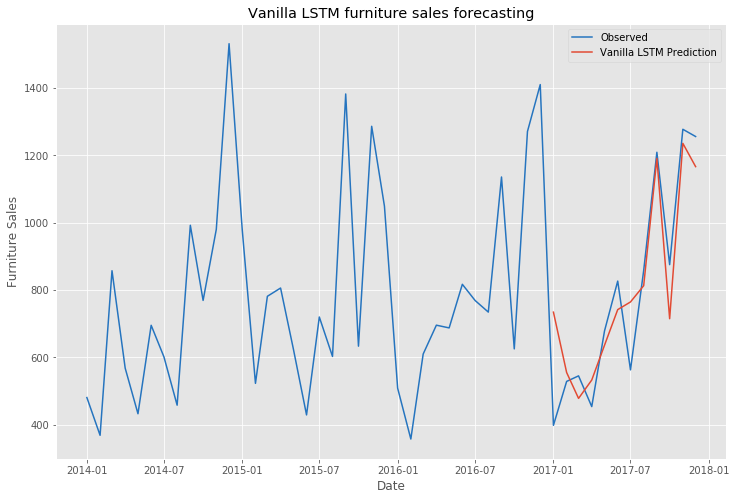

In [17]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [18]:
vanilla_lstm= performance(df[-12:],final_vanilla)
vanilla_lstm

{'MSE': 17700.46, 'RMSE': 133.04, 'MAPE': 17.28}

### Stacked LSTM

In [19]:
######
n=3
store2= np.zeros((12,n))
for i in range(n):
    model_stacked = Sequential()
    #In stacked LSTM, we should output a sequence rather than a single value for each input -> return_sequences=True
    model_stacked.add(LSTM(50, activation='relu', return_sequences = True, input_shape=(12, 1)))
    model_stacked.add(LSTM(50, activation='relu'))
    model_stacked.add(Dense(100, activation='relu'))
    model_stacked.add(Dense(50, activation='relu'))
    model_stacked.add(Dense(1))
    model_stacked.compile(optimizer='adam', loss='mse')
    model_stacked.fit_generator(generator,epochs=200)
    
    pred_list_s = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list_s.append(model_stacked.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list_s[j]]],axis=1)

    df_predict_stacked = pd.DataFrame(scaler.inverse_transform(pred_list_s),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store2[:,i]=df_predict_stacked['Prediction']
print(store2)

Epoch 1/200
3/3 [==============================] - 4s 1s/step - loss: 0.2456
Epoch 2/200
3/3 [==============================] - 0s 25ms/step - loss: 0.2242
Epoch 3/200
3/3 [==============================] - 0s 37ms/step - loss: 0.2027
Epoch 4/200
3/3 [==============================] - 0s 35ms/step - loss: 0.1760
Epoch 5/200
3/3 [==============================] - 0s 33ms/step - loss: 0.1458
Epoch 6/200
3/3 [==============================] - 0s 29ms/step - loss: 0.1137
Epoch 7/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0800
Epoch 8/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0838
Epoch 9/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0926
Epoch 10/200
3/3 [==============================] - 0s 40ms/step - loss: 0.0904
Epoch 11/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0764
Epoch 12/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0730
Epoch 13/200
3/3 [==============================] -

3/3 [==============================] - 0s 33ms/step - loss: 0.1999
Epoch 5/200
3/3 [==============================] - 0s 32ms/step - loss: 0.1765
Epoch 6/200
3/3 [==============================] - 0s 57ms/step - loss: 0.1469
Epoch 7/200
3/3 [==============================] - 0s 58ms/step - loss: 0.1219
Epoch 8/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0878
Epoch 9/200
3/3 [==============================] - 0s 48ms/step - loss: 0.0750
Epoch 10/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0959
Epoch 11/200
3/3 [==============================] - 0s 98ms/step - loss: 0.0867
Epoch 12/200
3/3 [==============================] - 0s 46ms/step - loss: 0.0734
Epoch 13/200
3/3 [==============================] - 0s 84ms/step - loss: 0.0705
Epoch 14/200
3/3 [==============================] - 0s 48ms/step - loss: 0.0715
Epoch 15/200
3/3 [==============================] - 0s 67ms/step - loss: 0.0730
Epoch 16/200
3/3 [==============================] - 0s 58m

3/3 [==============================] - 0s 40ms/step - loss: 0.0857
Epoch 8/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0758
Epoch 9/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0955
Epoch 10/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0890
Epoch 11/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0842
Epoch 12/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0713
Epoch 13/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0763
Epoch 14/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0752
Epoch 15/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0753
Epoch 16/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0747
Epoch 17/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0753
Epoch 18/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0733
Epoch 19/200
3/3 [==============================] - 0s 

In [20]:
final_stacked2= np.zeros((store2.shape[0],1))
for i in range(store2.shape[0]):
    
    final_stacked2[i]=np.mean(store2[i,:])
final_stacked2=final_stacked2.reshape((12,))

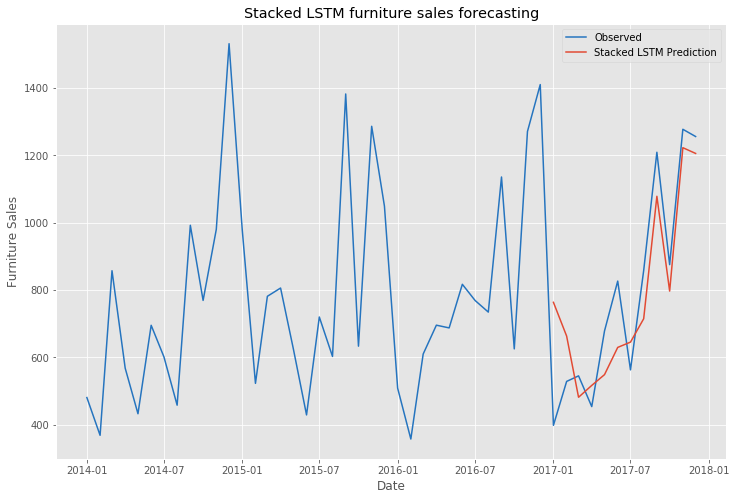

In [21]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,final_stacked2,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [22]:
stacked_lstm= performance(df[-12:],final_stacked2)
stacked_lstm

{'MSE': 22657.09, 'RMSE': 150.52, 'MAPE': 20.46}

### Bidirectional LSTM

In [23]:
# define model
warnings.filterwarnings("ignore")
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(12, 1)))
model_bi.add(Dense(1))
model_bi.compile(optimizer='adam', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
model_bi.fit_generator(generator,epochs=200)

Epoch 1/200
3/3 [==============================] - 5s 2s/step - loss: 0.2467
Epoch 2/200
3/3 [==============================] - 0s 24ms/step - loss: 0.2105
Epoch 3/200
3/3 [==============================] - 0s 35ms/step - loss: 0.1824
Epoch 4/200
3/3 [==============================] - 0s 34ms/step - loss: 0.1562
Epoch 5/200
3/3 [==============================] - 0s 38ms/step - loss: 0.1261
Epoch 6/200
3/3 [==============================] - 0s 32ms/step - loss: 0.1061
Epoch 7/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0908
Epoch 8/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0789
Epoch 9/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0684
Epoch 10/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0705
Epoch 11/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0738
Epoch 12/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0751
Epoch 13/200
3/3 [==============================] -

In [25]:
pred_list_b = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_b.append(model_bi.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=df[-n_input:].index, columns=['Prediction'])

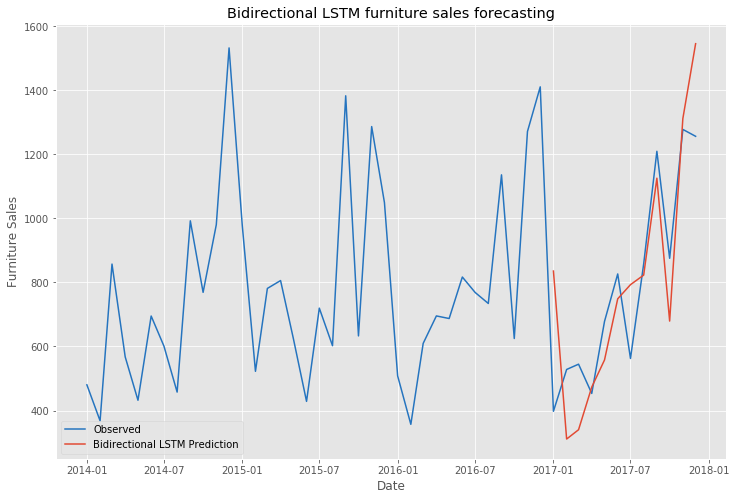

In [26]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [27]:
bi_lstm= performance(df[-12:],df_predict_bi['Prediction'] )
bi_lstm

{'MSE': 40537.75, 'RMSE': 201.34, 'MAPE': 26.7}

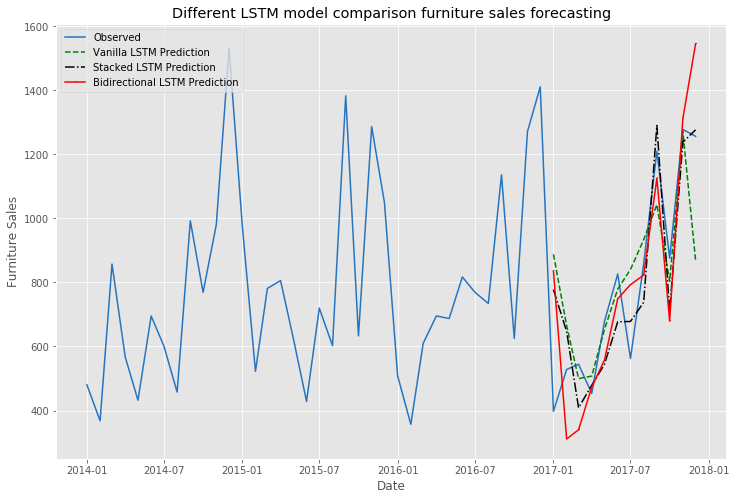

In [28]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='g')
#STacked LSTM
plt.plot(df[36:].index,df_predict_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="black")
#Bidirectional LSTM
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')
plt.title('Different LSTM model comparison furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend(loc='upper left')
plt.show()

### LSTM model 1

In [29]:
X = df.values

In [30]:
# Transform Time Series to Supervised Learning
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
# Make a differenced series to make time-series stationary
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [31]:
# Transform Time Series to Stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [32]:
# Transform Time Series to Supervised Learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [33]:
train_size = int(len(df) * 0.75)
trainset, testset= supervised_values[0:-12], supervised_values[-12:]

In [34]:
# Scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [35]:
#  Invert the scale on forecasts to the original scale
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [36]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [37]:
# fit an LSTM network to train the data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        #epoch can be changed to 1
        model.fit(X, y, epochs=5, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [38]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Train on 35 samples
Epoch 1/5
35/35 [==============================] - 3s 76ms/sample - loss: 0.2302
Epoch 2/5
35/35 [==============================] - 0s 7ms/sample - loss: 0.2282
Epoch 3/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.2261
Epoch 4/5
35/35 [==============================] - 0s 9ms/sample - loss: 0.2239
Epoch 5/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.2217
Train on 35 samples
Epoch 1/5
35/35 [==============================] - 0s 9ms/sample - loss: 0.2189
Epoch 2/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.2172
Epoch 3/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.2149
Epoch 4/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.2125
Epoch 5/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.2101
Train on 35 samples
Epoch 1/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.2069
Epoch 2/5
35/35 [==============================] - 0s 4ms/s

35/35 [==============================] - 0s 3ms/sample - loss: 0.1431
Train on 35 samples
Epoch 1/5
35/35 [==============================] - 0s 2ms/sample - loss: 0.1541
Epoch 2/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1545
Epoch 3/5
35/35 [==============================] - 0s 6ms/sample - loss: 0.1481
Epoch 4/5
35/35 [==============================] - 0s 7ms/sample - loss: 0.1481
Epoch 5/5
35/35 [==============================] - 0s 2ms/sample - loss: 0.1428
Train on 35 samples
Epoch 1/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1544
Epoch 2/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1542
Epoch 3/5
35/35 [==============================] - 0s 2ms/sample - loss: 0.1477
Epoch 4/5
35/35 [==============================] - 0s 4ms/sample - loss: 0.1476
Epoch 5/5
35/35 [==============================] - 0s 7ms/sample - loss: 0.1425
Train on 35 samples
Epoch 1/5
35/35 [==============================] - 0s 2ms/sample - los

35/35 [==============================] - 0s 4ms/sample - loss: 0.1203
Epoch 5/5
35/35 [==============================] - 0s 4ms/sample - loss: 0.1201
Train on 35 samples
Epoch 1/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1338
Epoch 2/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1321
Epoch 3/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1211
Epoch 4/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1196
Epoch 5/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1194
Train on 35 samples
Epoch 1/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1323
Epoch 2/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1309
Epoch 3/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1204
Epoch 4/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1189
Epoch 5/5
35/35 [==============================] - 0s 3ms/sample - loss: 0.1187
Train on 3

array([[ 0.2582311 ],
       [ 0.4677375 ],
       [-0.3779451 ],
       [ 0.46387377],
       [ 0.4338727 ],
       [ 0.00233605],
       [ 0.23573714],
       [ 0.3797067 ],
       [-0.37753183],
       [ 0.22688548],
       [-0.03485909],
       [-0.75516677],
       [-0.10929358],
       [ 0.18906975],
       [ 0.12325037],
       [ 0.03660955],
       [ 0.2810053 ],
       [ 0.41619334],
       [ 0.01749462],
       [ 0.37673146],
       [-0.849453  ],
       [ 0.6970408 ],
       [-0.33491054],
       [-0.18303934],
       [-0.0845381 ],
       [ 0.34391138],
       [ 0.05611862],
       [-0.00136128],
       [ 0.15523386],
       [ 0.06454938],
       [ 0.23190877],
       [ 0.2987897 ],
       [-0.2545952 ],
       [ 0.5848633 ],
       [-0.3527927 ]], dtype=float32)

In [39]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [40]:
# walk-forward validation on the test data
predictions_lstm1 = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_lstm1.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=1094.239927, Expected=1410.719808
Month=2, Predicted=457.782333, Expected=397.602133
Month=3, Predicted=739.253525, Expected=528.179800
Month=4, Predicted=692.057290, Expected=544.672240
Month=5, Predicted=705.854094, Expected=453.297905
Month=6, Predicted=704.034629, Expected=678.302328
Month=7, Predicted=797.554098, Expected=826.460291
Month=8, Predicted=943.032473, Expected=562.524857
Month=9, Predicted=876.621671, Expected=857.881889
Month=10, Predicted=871.609111, Expected=1209.508583
Month=11, Predicted=1146.921949, Expected=875.362728
Month=12, Predicted=1152.561816, Expected=1277.817759


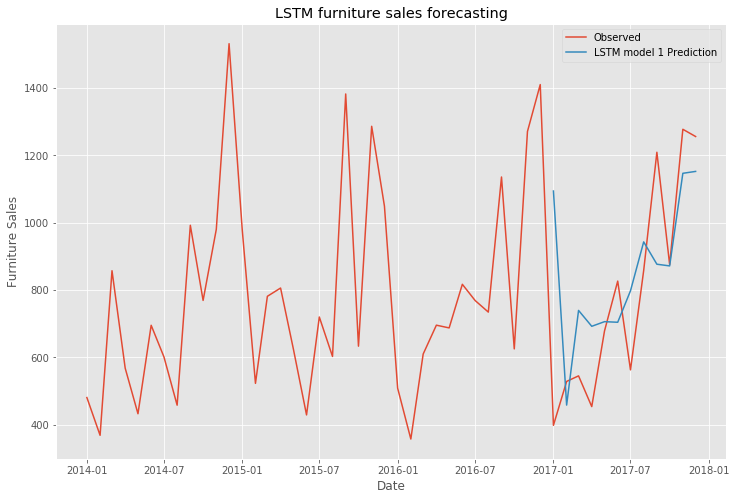

In [41]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 1 Prediction")
plt.title('LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [42]:
lstm1= performance(raw_values[-12:], predictions_lstm1)
lstm1

{'MSE': 66840.61, 'RMSE': 258.54, 'MAPE': 32.83}